/var/folders/nh/6r_l73vn5p1cbcbs3y1lp8j80000gn/T/ipykernel_23545/3781509410.py:186: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(swaves_times, freqs, processed_swaves_data,  cmap = 'viridis', vmin = np.percentile(processed_swaves_data, 1), vmax = np.percentile(processed_swaves_data, 99))


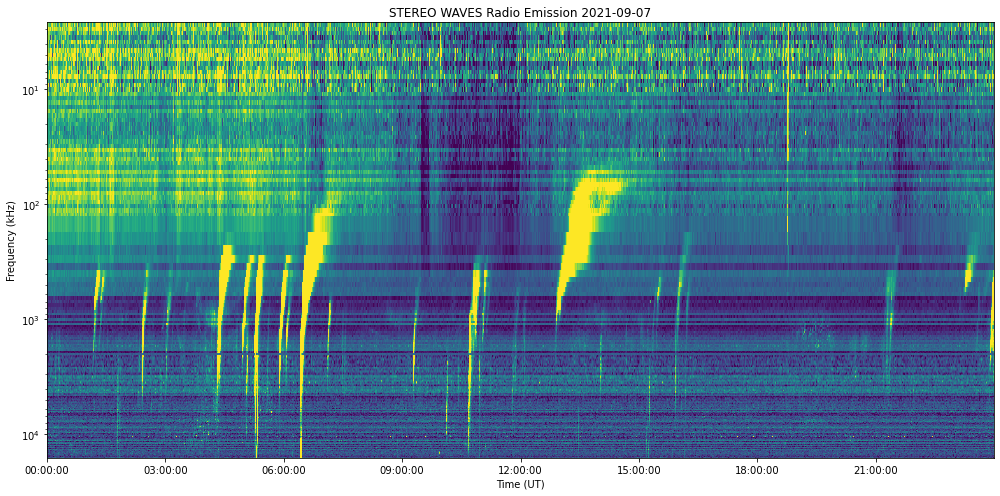

In [12]:
from sunpy.net import Fido, attrs as a
from stixpy.net.client import STIXClient
from sunpy.timeseries import TimeSeries
from stixpy import timeseries
import matplotlib.pyplot as plt
import sys
import matplotlib.dates as mdates
import datetime
import numpy as np
from datetime import date, timedelta
import pandas as pd
import requests
from scipy.io import readsav
from scipy.interpolate import griddata
from scipy import interpolate

#### SAMPLE INPUTS ####
# start_day_sample = '2020-11-18'
# end_day_sample = '2020-11-19'

start_day_sample = '2021-09-07'
end_day_sample = '2021-09-08'

sample_path = '/Users/thomas/SS Research Project/week 1'
#__________________________________



#### IN THIS SAMPLE IT WILL RETURN DATA FOR THE FULL DAY 2020-11-18 ####
#### ALSO RETURNS A LIST OF STRINGS OF THE OBSERVED DAYS ####
def get_swaves_sav(start_day, end_day, path):

	start_year = int(start_day[0:4])
	start_month = int(start_day[5:7])
	start_day = int(start_day[8:10])
	end_year = int(end_day[0:4])
	end_month = int(end_day[5:7])
	end_day = int(end_day[8:10])
	start_year_str = str(start_year)

	sdate = datetime.date(start_year,start_month,start_day) 
	edate = datetime.date(end_year,end_month,end_day)
	date_list = pd.date_range(sdate,edate - timedelta(days=1), freq='d')

	date_list_strings = []
	for i in range(0, np.size(date_list)):
		date = str(date_list[i])
		start_year_string = str(date[0:4])
		start_month_string = str(date[5:7])
		start_day_string = str(date[8:10])
		date_combined = start_year_string + start_month_string + start_day_string
		date_list_strings.append(date_combined)

	for i in range(0, np.size(date_list_strings)):
		url = 'https://solar-radio.gsfc.nasa.gov/data/stereo/new_summary/' + start_year_str + '/swaves_average_' + date_list_strings[i] + '_a.sav'
		r = requests.get(url, allow_redirects=True)
		open(path + '/swaves_' + date_list_strings[i] + '_a.sav' , 'wb').write(r.content)
	return (date_list_strings)
#__________________________________



#### DOWLOADING DATA FOR 2020-11-18 ####
date_list_strings = get_swaves_sav(start_day_sample, end_day_sample, sample_path)
#__________________________________



#### READ THE DOWNLOADED SAV FILES ####
#### RETURN LIST OF FREQUENCIES AND FORMATTED DATA (2-D DYNAMIC SPECTRUM) ####
#### PROVIDE THE PATH TO WHERE THE SAV FIKES WERE DOWNLOADED ####
#### PROVIDE THE LIST OF STRINGS RETURNED FROM get_swaves_sav ####
def read_swaves_sav(path, date_list_strings):

	data_swaves = []
	for i in range(0, np.size(date_list_strings)):
		data = readsav(path + '/swaves_'+ date_list_strings[0]+ '_a.sav')
		data_swaves.append(data)


	proccessed_swaves_arrays = []
	swaves_freqs = data_swaves[0]['frequencies']
	for i in range(0, np.size(date_list_strings)):

		swaves_freqs = data_swaves[i]['frequencies']
		swaves_back = data_swaves[i]['back']
		swaves_spec = data_swaves[i]['spectrum']
		proccessed_swaves_arrays.append(swaves_spec.T) # dont do transpose if doing backsub

	combined_swaves_data =  np.hstack(proccessed_swaves_arrays)

	return (combined_swaves_data, swaves_freqs)
#__________________________________



read_swaves_sav = read_swaves_sav(sample_path, date_list_strings)
#__________________________________



#### THE 2-D DYNAMIC SPECTRA AND THE FREQUENCIES OF THE SWAVES DATA ####
sample_data = read_swaves_sav[0]
sample_freqs = read_swaves_sav[1]
#__________________________________



#### PROCESS SWAVES DATA ####
#### RETURNS, DATA, FREQUENCIES, AND DATETIMES ####
def swaves_processing(data, freq, start, end):

	new_data = data.copy()

	# REMOVING FREQUENCY BANDS CONTAINONY ONLY ZEROES
	for i in range (0, new_data.shape[0]):
		if np.mean(new_data[i, :]) == 0:
			new_data[i, :] = np.nan


	# REMOVING VALUES < 0
	new_data[new_data < 0] = np.nan

	
	# CONSTRUCTING DATETIMES
	start_year = int(start[0:4])
	start_month = int(start[5:7])
	start_day = int(start[8:10])
	end_year = int(end[0:4])
	end_month = int(end[5:7])
	end_day = int(end[8:10])
	sdate = datetime.date(start_year,start_month,start_day) 
	edate = datetime.date(end_year,end_month,end_day)

	observation_start_time = datetime.datetime(sdate.year, sdate.month, sdate.day, 0, 0)
	date_list = pd.date_range(sdate,edate - timedelta(days=1), freq='d')
	date_list_strings = []

	for i in range(0, np.size(date_list)):
		date = str(date_list[i])
		start_year_string = str(date[0:4])
		start_month_string = str(date[5:7])
		start_day_string = str(date[8:10])
		date_combined = start_year_string + start_month_string + start_day_string
		date_list_strings.append(date_combined)

	time_res = timedelta(seconds=60)
	swaves_epoch = []
	swaves_epoch.append(observation_start_time)
	for i in range(0, (24 * len(date_list_strings) * 60) - 1):
	    swaves_epoch.append(swaves_epoch[-1] + time_res)

	# PERFORMING INTERPOLATION
	x = np.arange(0, new_data.shape[1])
	y = np.arange(0, new_data.shape[0])
	new_data = np.ma.masked_invalid(new_data)
	xx, yy = np.meshgrid(x, y)

	mean =  np.mean(new_data)
	x1 = xx[~new_data.mask]
	y1 = yy[~new_data.mask]
	newarr = new_data[~new_data.mask]
	GD1 = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy), method='cubic', fill_value = mean)

	return (swaves_epoch, freq, GD1)
#__________________________________



stereo_process_return = swaves_processing(sample_data, sample_freqs, start_day_sample, end_day_sample)
#__________________________________



swaves_times =  stereo_process_return[0]
freqs = stereo_process_return[1]
processed_swaves_data = stereo_process_return[2]
#__________________________________



#### PLOTTING SWAVES DATA ####
def plot_swaves(data, freqs, times):
    My_FIGURE = plt.figure(figsize=(14.,7.))
    ax = plt.subplot2grid((1, 1), (0, 0))
    ax.pcolormesh(swaves_times, freqs, processed_swaves_data,  cmap = 'viridis', vmin = np.percentile(processed_swaves_data, 1), vmax = np.percentile(processed_swaves_data, 99))
    ax.xaxis_date()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(date_format)
    plt.xlabel("Time (UT)")
    plt.ylabel("Frequency (kHz)")
    ax.set_title('STEREO WAVES Radio Emission '+start_day_sample)
    plt.ylim(freqs.max(), freqs.min())
    plt.yscale('log')
    My_FIGURE.tight_layout()
    My_FIGURE.savefig(sample_path + "/SWAVES_plot.png")
#__________________________________


#### PLOTTING ####
plot_swaves(processed_swaves_data, freqs, swaves_times)
plt.show()